# Backdoor v2: Using `Re78` - `Re75`

Using linear regression to model using a backdoor estimator on `Re78` - `Re75` before and after job training.

In [1]:
import sys

sys.path.append("../")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils.backdoor_utils import backdoor_lr, backdoor_param_a, mean_diff_estimator
from utils.bootstrap import bootstrap, bootstrap_experiment

In [3]:
lalonde_exp = pd.read_csv("../data/lalonde_exp.csv")
lalonde_obs = pd.read_csv("../data/lalonde_psid.csv")

In [4]:
lalonde_exp["re78_re75"] = lalonde_exp["re78"] - lalonde_exp["re75"]
lalonde_obs["re78_re75"] = lalonde_obs["re78"] - lalonde_obs["re75"]

Our average treatment effect is now a difference of differences

$\beta = E[Y^a - Y^{a'}] = E[(Re_{78} - Re_{75})^{a} - (Re_{78} - Re_{75})^{a'}]$

* We suspect that those with a higher initial income benefit less from job training, but have higher earnings in 1978.
* This is because those who start with higher salaries are likely to earn more in the future.
* Higher salary earners are also less likely to go for job training and also less likely to benefit from it.
* To look at this, let's see the distribution of incomes in our observational data.

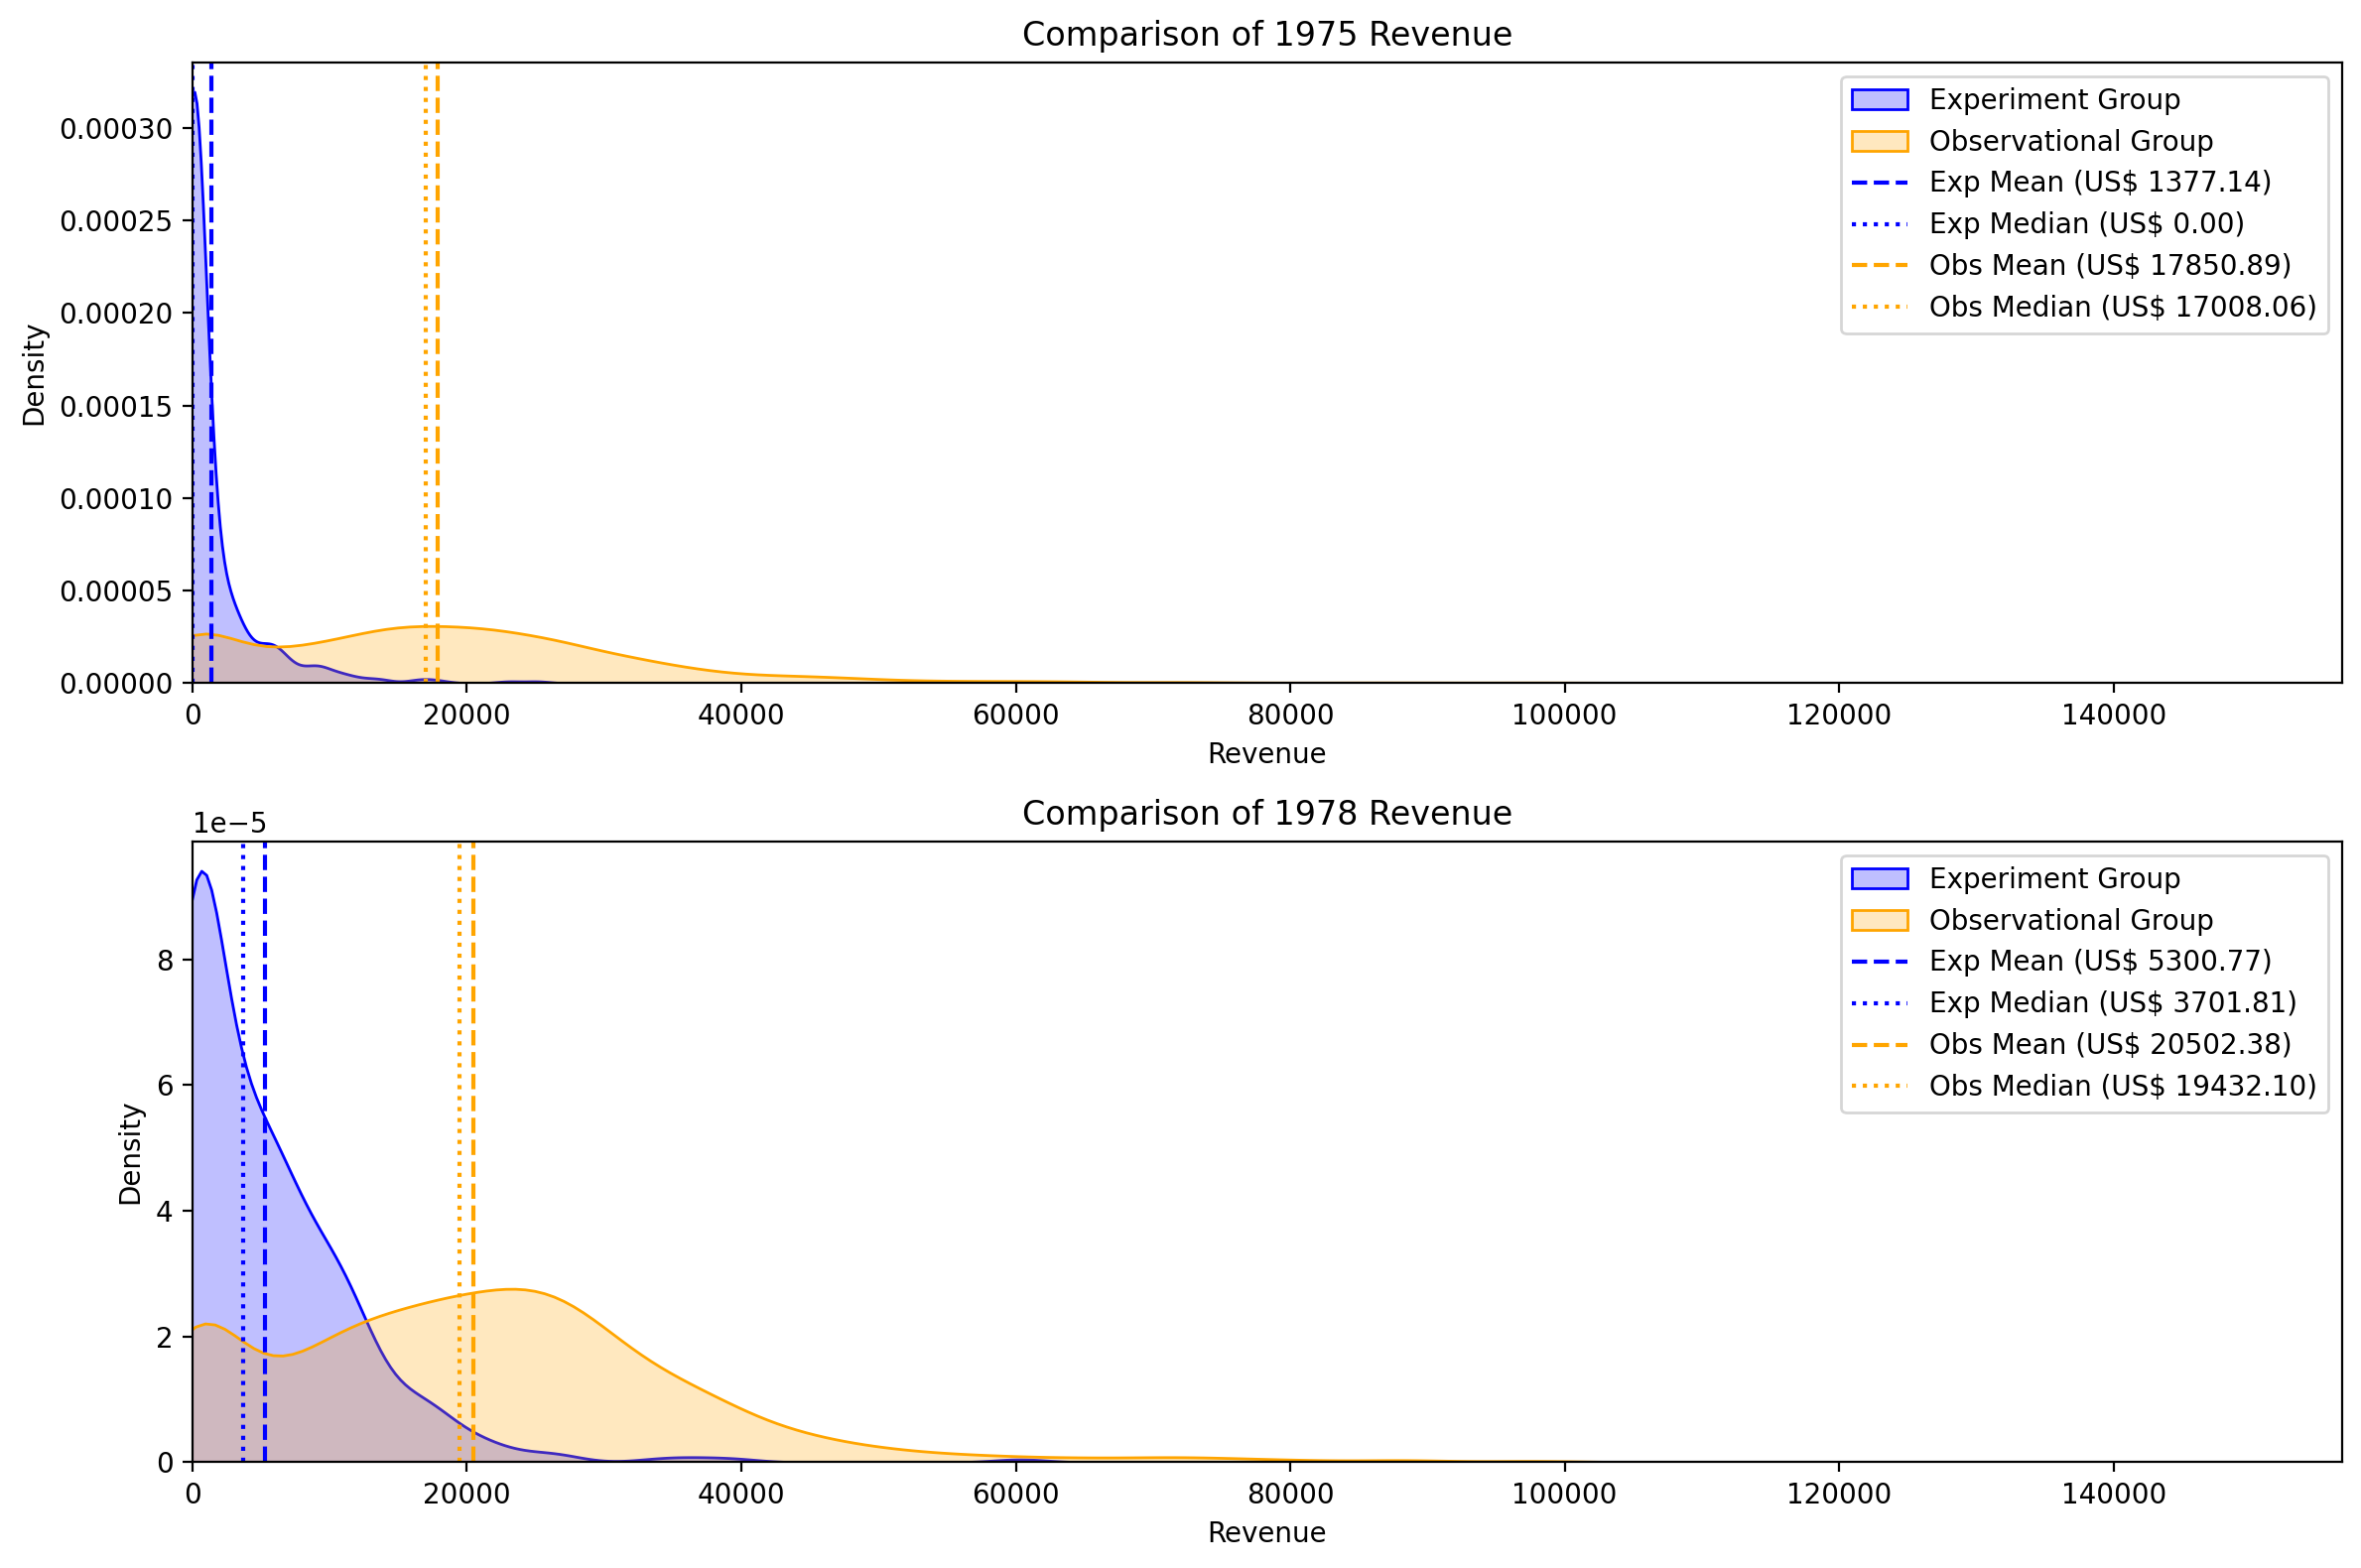

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), dpi=200)

columns = ["re75", "re78"]
titles = ["1975 Revenue", "1978 Revenue"]

global_min = min(lalonde_exp[columns].min().min(), lalonde_obs[columns].min().min())
global_max = max(lalonde_exp[columns].max().max(), lalonde_obs[columns].max().max())

for i, column in enumerate(columns):
    sns.kdeplot(
        lalonde_exp[column],
        ax=axes[i],
        color="blue",
        label="Experiment Group",
        fill=True,
    )
    sns.kdeplot(
        lalonde_obs[column],
        ax=axes[i],
        color="orange",
        label="Observational Group",
        fill=True,
    )

    exp_mean = lalonde_exp[column].mean()
    exp_median = lalonde_exp[column].median()
    obs_mean = lalonde_obs[column].mean()
    obs_median = lalonde_obs[column].median()

    axes[i].axvline(
        exp_mean, color="blue", linestyle="--", label=f"Exp Mean (US$ {exp_mean:.2f})"
    )
    axes[i].axvline(
        exp_median,
        color="blue",
        linestyle=":",
        label=f"Exp Median (US$ {exp_median:.2f})",
    )

    axes[i].axvline(
        obs_mean, color="orange", linestyle="--", label=f"Obs Mean (US$ {obs_mean:.2f})"
    )
    axes[i].axvline(
        obs_median,
        color="orange",
        linestyle=":",
        label=f"Obs Median (US$ {obs_median:.2f})",
    )

    axes[i].set_title(f"Comparison of {titles[i]}")
    axes[i].set_xlabel("Revenue")
    axes[i].set_ylabel("Density")
    axes[i].set_xlim(global_min, global_max)
    axes[i].legend()

plt.tight_layout()
plt.show()

* The above graph shows us that those in the observational group are at typically higher 

## Naive Estimate

### Experimental Data

In [6]:
ci = bootstrap(
    lalonde_exp,
    mean_diff_estimator,
    50,
    95,
    treatment_col="treat",
    outcome_col="re78_re75",
)

In [7]:
print(
    f"Causal estimate of `Re78` in experimental data as a difference of means is "
    f"US${ci[0]:.2f} ± [{ci[1]:.2f}, {ci[2]:.2f}]"
)

Causal estimate of `Re78` in experimental data as a difference of means is US$1582.83 ± [49.59, 3126.33]


## Backdoor Estimate

### Experimental Data

In [8]:
backdoor_boostrap_results = bootstrap_experiment(
    df=lalonde_exp,
    function=backdoor_lr,
    num_exp=50,
    n=50,
    ci=95,
    treatment_col="treat",
    outcome_col="re78_re75",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75",
    ],
)

Running experiments: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.77it/s]


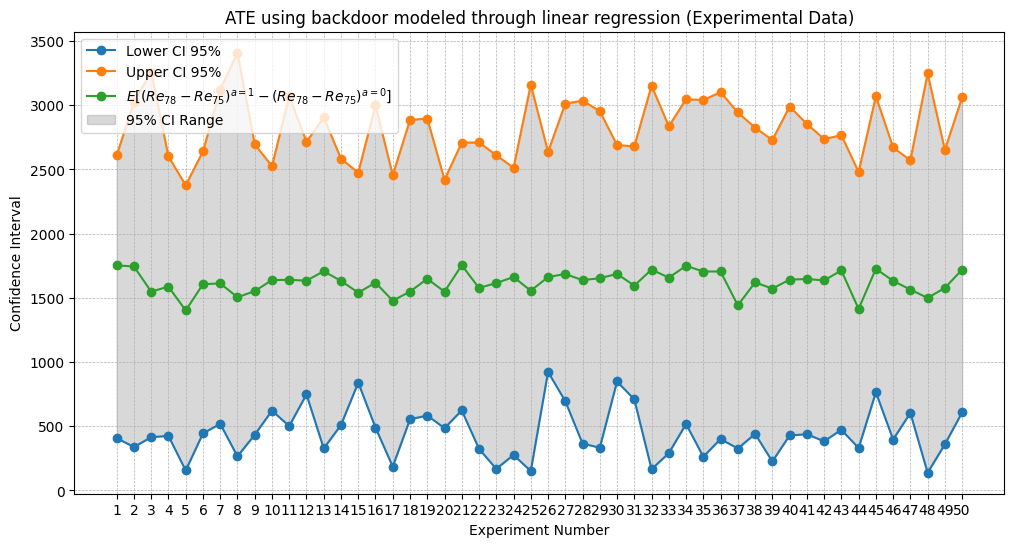

In [9]:
ci_df = pd.DataFrame(
    backdoor_boostrap_results, columns=["mean", "lower_ci", "upper_ci"]
)
ci_df["experiment"] = range(1, len(ci_df) + 1)

plt.figure(figsize=(12, 6))

plt.plot(ci_df["experiment"], ci_df["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(
    ci_df["experiment"],
    ci_df["mean"],
    label="$E[(Re_{78} - Re_{75})^{a=1} - (Re_{78} - Re_{75})^{a=0}]$",
    marker="o",
)

plt.fill_between(
    ci_df["experiment"],
    ci_df["lower_ci"],
    ci_df["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df["experiment"])
plt.xlabel("Experiment Number")
plt.ylabel("Confidence Interval")
plt.title("ATE using backdoor modeled through linear regression (Experimental Data)")
plt.legend()
plt.show()

In [10]:
ci_df.sample(10)

,mean,lower_ci,upper_ci,experiment
24,1555.873632,150.946338,3161.014321,25
22,1615.632520,168.283163,2611.189527,23
18,1648.290597,583.752296,2896.859487,19
38,1572.199611,226.027462,2729.407149,39
35,1705.530509,400.715786,3102.688739,36
47,1499.541306,138.403920,3247.672199,48
17,1548.869122,554.558369,2885.795734,18
39,1641.824989,428.796316,2989.974511,40
29,1686.362865,848.917126,2690.069230,30
40,1647.106947,438.304911,2854.979450,41


### Observational Data

In [11]:
backdoor_boostrap_results = bootstrap_experiment(
    df=lalonde_obs,
    function=backdoor_lr,
    num_exp=50,
    n=50,
    ci=95,
    treatment_col="treat",
    outcome_col="re78_re75",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75",
    ],
)

Running experiments: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:46<00:00,  1.07it/s]


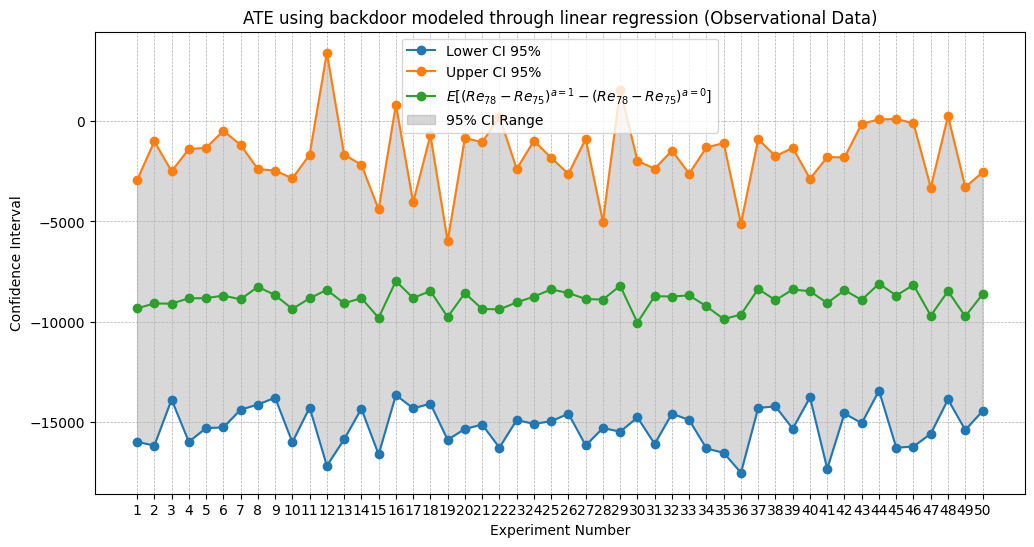

In [12]:
ci_df = pd.DataFrame(
    backdoor_boostrap_results, columns=["mean", "lower_ci", "upper_ci"]
)
ci_df["experiment"] = range(1, len(ci_df) + 1)

plt.figure(figsize=(12, 6))

plt.plot(ci_df["experiment"], ci_df["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(
    ci_df["experiment"],
    ci_df["mean"],
    label="$E[(Re_{78} - Re_{75})^{a=1} - (Re_{78} - Re_{75})^{a=0}]$",
    marker="o",
)

plt.fill_between(
    ci_df["experiment"],
    ci_df["lower_ci"],
    ci_df["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df["experiment"])
plt.xlabel("Experiment Number")
plt.ylabel("Confidence Interval")
plt.title("ATE using backdoor modeled through linear regression (Observational Data)")
plt.legend()
plt.show()

In [13]:
ci_df.sample(10)

,mean,lower_ci,upper_ci,experiment
23,-8752.490757,-15099.833122,-974.586569,24
44,-8697.929209,-16290.037035,118.971215,45
6,-8886.662848,-14391.839015,-1181.495959,7
18,-9767.090382,-15896.910279,-5981.378997,19
15,-7977.440403,-13662.259591,830.143200,16
10,-8836.482202,-14285.430737,-1665.924853,11
27,-8898.697672,-15310.594699,-5001.400241,28
13,-8824.099043,-14344.070192,-2169.090996,14
8,-8676.505314,-13794.873586,-2458.737751,9
33,-9236.761080,-16329.326392,-1300.233460,34


But this estimate doesn't seem plausible with the observational data.

In [14]:
ci = bootstrap(
    lalonde_obs,
    backdoor_lr,
    50,
    95,
    treatment_col="treat",
    outcome_col="re78_re75",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75",
    ],
)

print(
    f"Causal estimate of `Re78` - `Re75` in observational data as a difference of means is "
    f"US${ci[0]:.2f} ± [{ci[1]:.2f}, {ci[2]:.2f}]"
)

Causal estimate of `Re78` - `Re75` in observational data as a difference of means is US$-9200.54 ± [-15795.52, -2132.38]


## Using a's parameter

### Experimental Data

In [15]:
backdoor_result = backdoor_param_a(
    lalonde_exp,
    "treat",
    "re78_re75",
    ["age", "education", "black", "hispanic", "married", "re74", "re75"],
)
print(
    f"The difference between the treatment and no-treatment groups is {backdoor_result:.2f}."
)

The difference between the treatment and no-treatment groups is 1682.59.


In [16]:
backdoor_boostrap_results = bootstrap_experiment(
    df=lalonde_exp,
    function=backdoor_param_a,
    num_exp=50,
    n=50,
    ci=95,
    treatment_col="treat",
    outcome_col="re78_re75",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75",
    ],
)

Running experiments: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.26it/s]


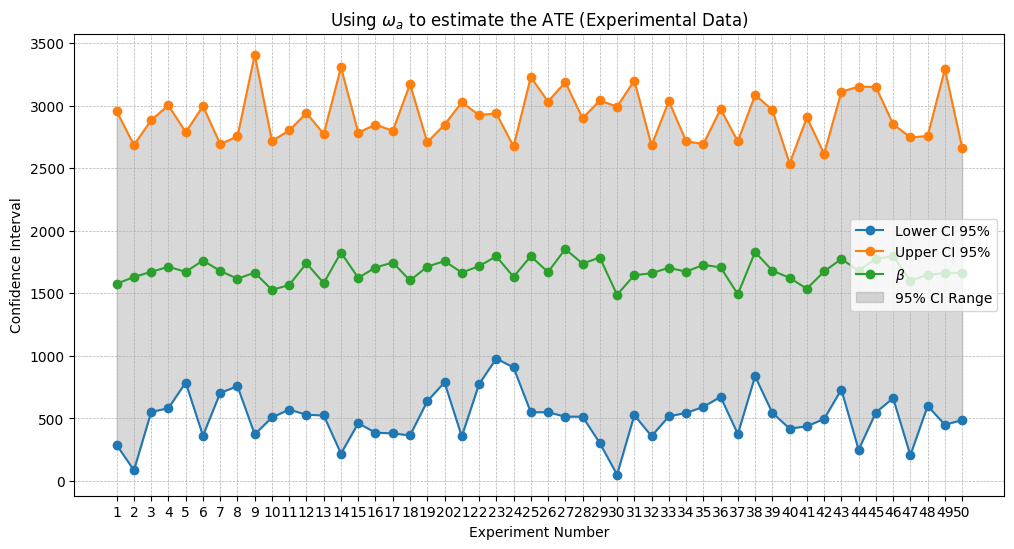

In [17]:
ci_df = pd.DataFrame(
    backdoor_boostrap_results, columns=["mean", "lower_ci", "upper_ci"]
)
ci_df["experiment"] = range(1, len(ci_df) + 1)

plt.figure(figsize=(12, 6))

plt.plot(ci_df["experiment"], ci_df["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["mean"], label="$\\beta$", marker="o")

plt.fill_between(
    ci_df["experiment"],
    ci_df["lower_ci"],
    ci_df["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df["experiment"])
plt.xlabel("Experiment Number")
plt.ylabel("Confidence Interval")
plt.title("Using $\\omega_{a}$ to estimate the ATE (Experimental Data)")
plt.legend()
plt.show()

In [18]:
ci_df.sample(10)

,mean,lower_ci,upper_ci,experiment
39,1623.704618,418.902512,2537.691442,40
43,1681.455078,249.544913,3153.336168,44
33,1673.558017,544.292413,2717.302589,34
49,1665.509393,487.315836,2665.444401,50
23,1632.526468,907.894231,2674.938252,24
34,1727.892090,592.644058,2694.006805,35
24,1796.924537,549.911766,3229.369801,25
12,1582.129513,523.993345,2774.745945,13
4,1672.616511,787.472555,2788.407930,5
15,1706.830133,385.933132,2850.191228,16


### Using Observational data

In [19]:
backdoor_result = backdoor_param_a(
    lalonde_obs,
    "treat",
    "re78_re75",
    ["age", "education", "black", "hispanic", "married", "re74", "re75"],
)
print(
    f"The difference between the treatment and no-treatment groups is {backdoor_result:.2f}."
)

The difference between the treatment and no-treatment groups is 859.77.


In [20]:
backdoor_boostrap_results = bootstrap_experiment(
    df=lalonde_obs,
    function=backdoor_param_a,
    num_exp=50,
    n=50,
    ci=95,
    treatment_col="treat",
    outcome_col="re78_re75",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75",
    ],
)

Running experiments: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.33it/s]


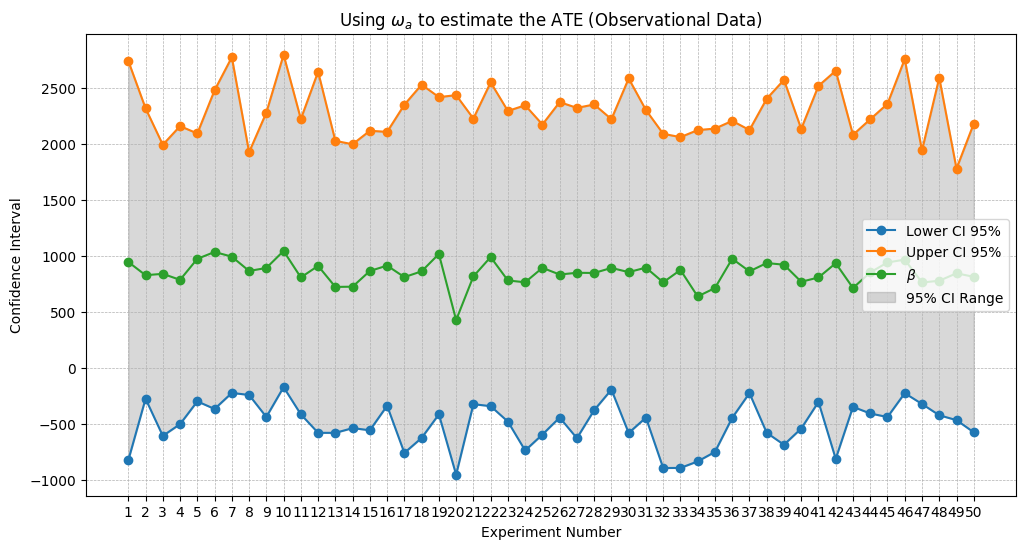

In [21]:
ci_df = pd.DataFrame(
    backdoor_boostrap_results, columns=["mean", "lower_ci", "upper_ci"]
)
ci_df["experiment"] = range(1, len(ci_df) + 1)

plt.figure(figsize=(12, 6))

plt.plot(ci_df["experiment"], ci_df["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["mean"], label="$\\beta$", marker="o")

plt.fill_between(
    ci_df["experiment"],
    ci_df["lower_ci"],
    ci_df["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df["experiment"])
plt.xlabel("Experiment Number")
plt.ylabel("Confidence Interval")
plt.title("Using $\\omega_{a}$ to estimate the ATE (Observational Data)")
plt.legend()
plt.show()

In [22]:
ci_df.sample(10)

,mean,lower_ci,upper_ci,experiment
49,812.938897,-577.086335,2182.999392,50
23,764.305683,-739.696097,2346.852988,24
9,1044.257292,-173.425272,2798.647516,10
19,426.291281,-956.355068,2437.251459,20
13,724.792568,-539.794769,1998.430026,14
38,921.352706,-688.421504,2573.851996,39
44,941.541245,-440.610398,2359.666488,45
14,865.219415,-558.771904,2118.840463,15
36,861.799803,-226.595893,2125.490111,37
24,893.190630,-597.210876,2174.792231,25


* We might be overfitting with the backdoor estimator
* The outcome is linearly dependent on A

In [23]:
ci = bootstrap(
    lalonde_obs,
    backdoor_param_a,
    50,
    95,
    treatment_col="treat",
    outcome_col="re78_re75",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75",
    ],
)

print(
    f"Causal estimate of `Re78` in observational data as a difference of means is "
    f"US${ci[0]:.2f} ± [{ci[1]:.2f}, {ci[2]:.2f}]"
)

Causal estimate of `Re78` in observational data as a difference of means is US$861.24 ± [-549.37, 2379.72]
